In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Calculate Dark Channel

In [24]:
def get_dark_channel(img, wind_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.copyMakeBorder(img,wind_size//2,wind_size//2,wind_size//2,wind_size//2,cv2.BORDER_CONSTANT,value=[255,255,255])    
    no_rows = img.shape[0]
    no_cols = img.shape[1]
    min_channel = np.zeros((no_rows, no_cols))
    for row in range(no_rows):
        for col in range(no_cols):
            min_channel[row-wind_size//2][col-wind_size//2] = np.min(img[row,col,:])
    for row in range(wind_size//2, no_rows-wind_size//2):
        for col in range(wind_size//2, no_cols-wind_size//2):
            dark_channel[row-wind_size//2][col-wind_size//2] = np.min(min_channel[row-wind_size//2:row+wind_size//2,col-wind_size//2:col+wind_size//2])
    return dark_channel

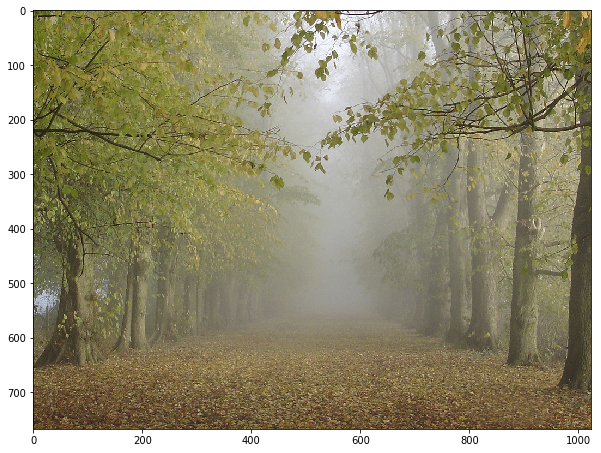

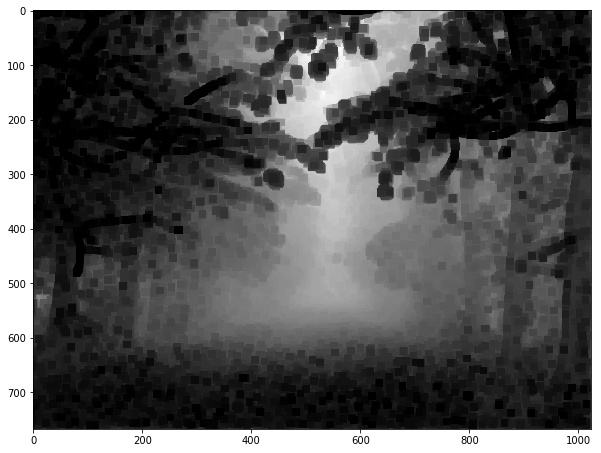

In [224]:
# img = cv2.imread("Dataset/O-Haze/hazy/40_outdoor_hazy.jpg")
# img = cv2.resize(img,(0,0),fx=0.25,fy=0.25)
# plt.imshow(img[...,::-1])
# plt.show()
# dark_channel_img = get_dark_channel(img, 15)
# plt.imshow(dark_channel_img,'gray')
# plt.show()
img = cv2.imread("Dataset/2.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img[...,::-1])
plt.show()
dark_channel_img = get_dark_channel(img, 15)
dark_channel_img = dark_channel_img.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(dark_channel_img,'gray')
plt.show()

# Estimate Atmospheric Light

In [225]:
def get_atm_light(im, dark_channel_img):
    img = im.copy()
    num_pixels = dark_channel_img.size
    num_brightest = num_pixels//1000
    haze_density_sort_idx = np.argsort(dark_channel_img,axis=None)[::-1]
    brightest = haze_density_sort_idx[0:num_brightest]
    brightest = np.unravel_index(brightest,dark_channel_img.shape)
    brightest_pixels = img[brightest]
    top_intensities = np.average(brightest_pixels, axis=1)
    max_intensity = np.argmax(top_intensities)
    A = brightest_pixels[max_intensity]
    img[brightest]=[255,0,0]
    row_min = np.min(brightest[0])
    row_max = np.max(brightest[0])
    col_min = np.min(brightest[1])
    col_max = np.max(brightest[1])
    cv2.rectangle(img, (col_min,row_min),(col_max,row_max),(0,0,255),thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(img[...,::-1])
    plt.show()
    return A

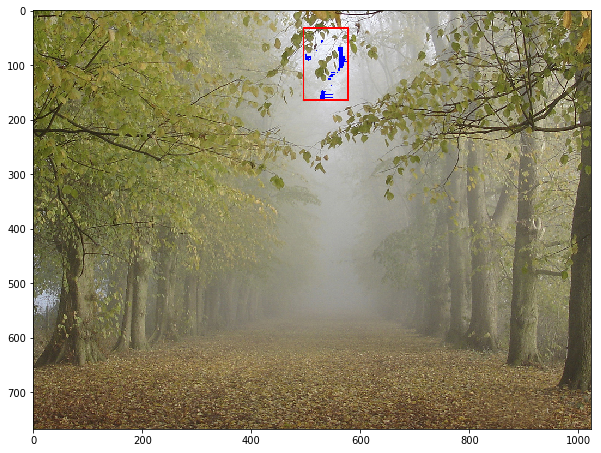

In [226]:
atm_light = get_atm_light(img,dark_channel_img)

# Estimate Transmission

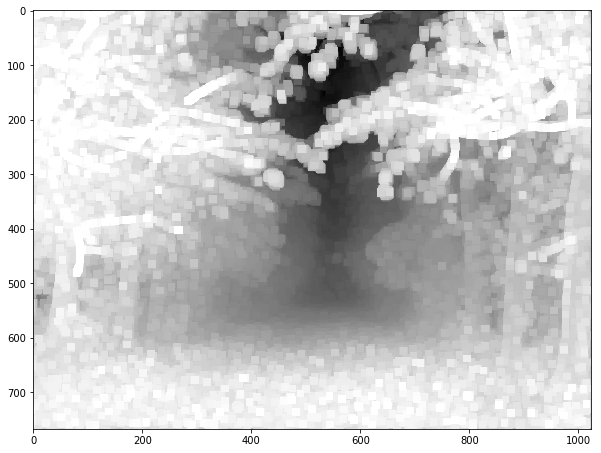

In [227]:
t_bar = get_dark_channel(img/atm_light,15)
trans_bar = 1-(0.85*t_bar)
plt.figure(figsize=(10,10))
plt.imshow(trans_bar,'gray')
plt.show()

# Transmission Refinement

In [228]:
def refine(img, transmission, radius, epsilon):
    mean_guide = cv2.blur(img,(radius,radius))
    mean_trans = cv2.blur(transmission,(radius,radius))
    mean_gt = cv2.blur(img * transmission, (radius,radius))
    
    a = mean_gt - mean_guide * mean_trans
    var_guide = cv2.blur(img * img,(radius,radius)) - (mean_guide * mean_guide)
    a = a/(var_guide + epsilon)
    b = mean_trans - a * mean_guide

    q = cv2.blur(a,(radius,radius)) * img + cv2.blur(b,(radius,radius))
    return q

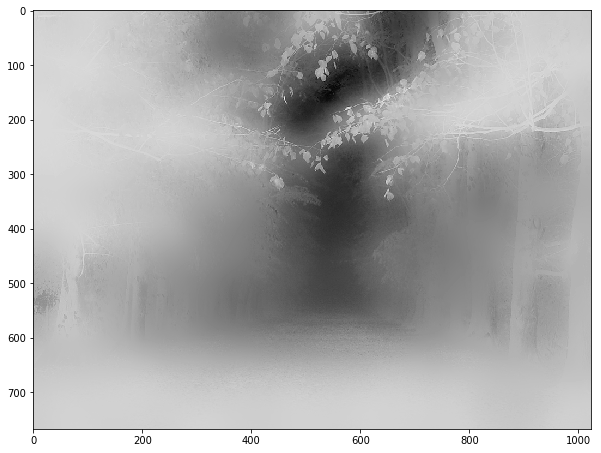

In [229]:
i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
t_refine = refine(i, trans_bar, 60, 0.0001)
plt.figure(figsize=(10,10))
plt.imshow(t_refine,'gray')
plt.show()

# Recovering the Image

In [237]:
def recover_image(img, trans_bar, atm_light, t0):
    trans_recover = np.copy(trans_bar)
    trans_recover[trans_recover < t0] = t0
    J = np.zeros((img.shape))
    J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0]
    J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1]
    J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2]
    return J

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


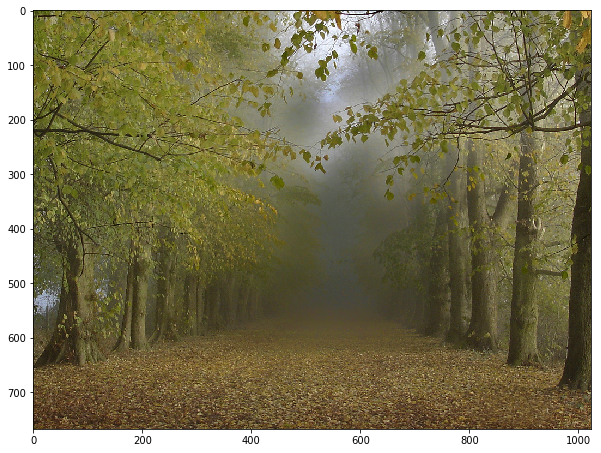

In [261]:
im = img.astype("double")
J = recover_image(im, t_refine, atm_light, 0.1)
plt.figure(figsize=(10,10))
J = np.int32(J)
plt.imshow(((J[...,::-1])))
plt.show()

# Depth Map

In [232]:
def depth_map(t_refine, beta):
    return (-np.log(t_refine)/beta)

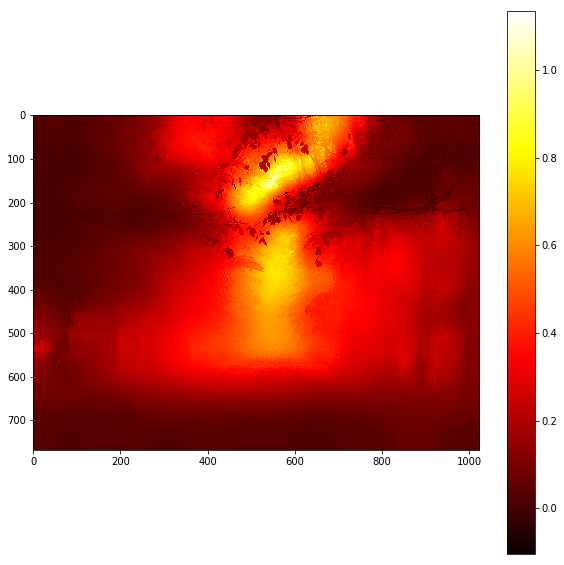

In [234]:
plt.figure(figsize=(10,10))
plt.imshow(depth_map(t_refine, 1),'hot')
plt.colorbar()
plt.show()